# Homegrown K-Nearest Neighbor

The following notebook is a continuation on the notebook: Recognize Handwriting with Sci-kit Learn. In this notebook I will try to make my own implementation of a K-Nearest Neighbor(KNN) algorithm and test it on the MNIST dataset. For the implementation I will be following the structure provided by Jason Brownlee [1].
This includes the following steps:
<ol>
<li><strong>Select programming language</strong>: Select the programming language you want to use for the implementation. This decision may influence the APIs and standard libraries you can use in your implementation.</li>
<li><strong>Select Algorithm</strong>: Select the algorithm that you want to implement from scratch. Be as specific as possible. This means not only the class, and type of algorithm, but also go as far as selecting a specific description or implementation that you want to implement.</li>
<li><strong>Select Problem:</strong> Select a canonical problem or set of problems you can use to test and validate your implementation of the algorithm. Machine learning algorithms do not exist in isolation.</li>
<li><strong>Research Algorithm</strong>: Locate papers, books, websites, libraries and any other descriptions of the algorithm you can read and learn from. Although you ideally want to have one keystone description of the algorithm from which to work, you will want to have multiple perspectives on the algorithm. This is useful because the multiple perspectives will help you to internalize the algorithm description faster and overcome roadblocks from any ambiguities or assumptions made in the description (there are always ambiguities in algorithm descriptions).</li>
<li><strong>Unit Test</strong>: Write unit tests for each function, even consider test driven development from the beginning of the project so that you are forced to understand the purpose and expectations of each unit of code before you implement them.</li>
</ol>

For this implementation I will be using Python inside of a Jupyter Notebook, the algorithm that I will implement will be a simple version of K Nearest Neighbor using Euclidean distance. I might later optimize this to be a weighted version that uses a different distance metric. The Problem that I will focus on is classification of images from the MNIST [2] dataset. This is a dataset consisting of 60000 images of written digits that are labeled.

## The algorithm

The KNN algorithm determines the classification of a new point by checking what labels the n-nearest points have. The algorithm then simply picks the same classification as the most recurring label. K-Nearest Neighbor is a so-called lazy-learning algorithm, this means that it does not need any training. The whole classification process executes at runtime, where it checks the distance from the predicted point to all available points in the dataset.
The KNN algorithm relies on three steps:
<ol>
    <li>
        Find the distance between the predicted point and all the existing data points and store this in an array.
        To find the Euclidean distance in n-dimensional space we can use the following formula:
        \begin{equation*}
        \sqrt{\sum_{i=1}^n (q_i-p_k)^2}
        \end{equation*}
    </li>
    <li>
        This array then needs to be sorted putting the shortest distances first.
    </li>
    <li>
        From the sorted array we look at the labels of the first n-data points and predict the new label based on the majority.
    </li>
</ol>

### Calculating Euclidean distance

By using numpy arrays, calculating the Euclidean distance becomes easier. It is possible to simply subtract and square whole numpy arrays. To gain one value we sum the L2 norm [3].

In [118]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


# import MNIST dataset according to sci-kit learn protocol
MNIST = datasets.load_digits()

X = MNIST.data
y = MNIST.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

def distance(img1, img2):
    '''Calculates the Euclidean distance between two images
    
    Paramaters:
    img1 (numpy array): Image data presented as a numpy array.
    img2 (numpy array): Image data presented as a numpy array.
    
    Returns:
    float: Euclidian distance
    '''
    return np.sqrt(sum((img1 - img2) ** 2))

# testing the function on sample data
obj1 = X_train[0]
obj2 = X_test[0]

print(distance(obj1, obj2))

45.05552130427524


### Visualizing distance

The interesting thing about calculating the distance between two images, is that it is the same operation as a difference blending mode in photoshop. This makes it possible to gain some visual understanding of what the K-Nearest Neighbor does.

To visualize the steps, we will take plots off the image array at different stages.



Distance between first two images: 125.0
Distance between first two images: 231.0


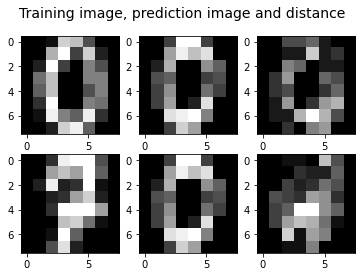

In [100]:
# plot first element from training set
train_image1 = X_train[18].reshape(8,8)
fig = plt.figure(1)
fig.add_subplot(2, 3, 1)
plt.imshow(train_image1, cmap=plt.cm.gray, interpolation='nearest')
plt.suptitle('Training image, prediction image and distance', fontsize=14, fontweight='regular')

#plot image to be predicted
predict_image1 = X_test[10].reshape(8,8)
fig.add_subplot(2, 3, 2)
fig = plt.imshow(predict_image1, cmap=plt.cm.gray, interpolation='nearest')

#plot distance between images
distance = np.sqrt((train_image1 - predict_image1) ** 2)
fig = plt.figure(1)
fig.add_subplot(2, 3, 3)
fig = plt.imshow(distance, cmap=plt.cm.gray, interpolation='nearest')

# plot second element from training set
train_image2 = X_train[21].reshape(8,8)
fig = plt.figure(1)
fig.add_subplot(2, 3, 4)
plt.imshow(train_image2, cmap=plt.cm.gray, interpolation='nearest')
# plt[0][0].suptitle('Images from training set', fontsize=14, fontweight='regular')

#plot image to be predicted
fig = plt.figure(1)
fig.add_subplot(2, 3, 5)
fig = plt.imshow(predict_image1, cmap=plt.cm.gray, interpolation='nearest')

#plot distance between images
distance2 = np.sqrt((train_image2 - predict_image1) ** 2)
fig = plt.figure(1)
fig.add_subplot(2, 3, 6)
fig = plt.imshow(distance2, cmap=plt.cm.gray, interpolation='nearest')

print('Distance between first two images: {}'.format(np.sum(distance)))
print('Distance between first two images: {}'.format(np.sum(distance2)))

### Bringing it all together

With the newly gained understanding of calculating distance between images, it is now possible to implement the remaining steps for the KNN algorithm.

Prediction is: 5
Accuracy is: 98.61%


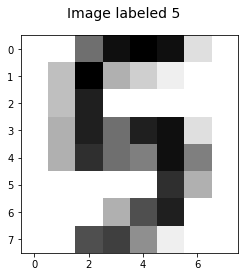

In [187]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from scipy import stats


# import MNIST dataset according to sci-kit learn protocol
MNIST = datasets.load_digits()

X = MNIST.data
y = MNIST.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)


def KNN(training_data, training_target, prediction_data, n_neighbors=3):
    '''Predicts label of data, based on K-Nearest Neighbor algorithm
    
    Paramaters:
    training_data (numpy array): An array containing the set of all training data, 
                                 with images being represented as a sub-array.
    training_target (numpy array): An array with the corresponding labels for the training_data.
    prediction_data (numpy array): An array with single image data to be classified.
    n_neighbors (int): A number representing the amount of close neighbors to take into consideration, 
                       default is 3.
    
    returns:
    Same format as elements in training target, with the predicted label.
    
    '''
    
    # list to store distances
    all_distances =  []
    
    # loop over all images in training set and calculate distance between it and the target image
    for i, image in enumerate(training_data):
        all_distances.append((np.sqrt(sum((image - prediction_data) ** 2)), training_target[i]))
    
    #sort list with distances
    all_distances.sort()
    
    # list to store the nearest n labels
    labels = []
    for item in all_distances[0:n_neighbors]:
        labels.append(item[1])
        
    # return the most common label
    return stats.mode(labels)[0][0]


# set what image from the test set to predict
prediction_index = 25

# render visual representation of the predicted image
predicted_image = X_test[prediction_index]
predicted_visual = X_test[prediction_index].reshape(8,8)
plt.imshow(predicted_visual, cmap=plt.cm.gray_r, interpolation='nearest')
plt.suptitle('Image labeled {}'.format(y_test[prediction_index]), fontsize=14, fontweight='regular')    


# run the KNN classifier and print the result
KNN_prediction = KNN(X_train, y_train, predicted_image, 3)
print('Prediction is: {}'.format(KNN_prediction))

# score the algorithm

score_counter = 0
for i, predicted in enumerate(y_test):
    if predicted == KNN(X_train, y_train, X_test[i], 3):
        score_counter += 1
        
accuracy = round((score_counter / len(y_test)) * 100, 2)

print('Accuracy is: {}%'.format(accuracy))
        


## Conclusion

The final code for implementing a K-Nearest Neighbor algorithm is fairly simple. The currently achieved accuracy is .3 percent higher than the Sci-Kit learn implementation. It does seem to run quite a bit slower. But the goal of this project was not to find the most optimized version of this algorithm, but simply to build a successful implementation.

It was interesting to think about ways to visualize this algorithm, seeing the labeled image, with the correct prediction is oddly satisfying.


# References

[1] J. Brownlee, “How to Implement a Machine Learning Algorithm in Code,” 2014. https://machinelearningmastery.com/how-to-implement-a-machine-learning-algorithm/ (accessed Nov. 21, 2020).

[2] Y. LeCun and C. Cortes, “MNIST handwritten digit database, Yann LeCun, Corinna Cortes and Chris Burges.” http://yann.lecun.com/exdb/mnist/ (accessed Nov. 21, 2020).

[3] S. Z. Li and A. Jain, Eds., “L2 norm,” in Encyclopedia of Biometrics, Boston, MA: Springer US, 2009, p. 883.